In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl") 

In [10]:
# Load the dataset
df = pd.read_csv('competition_data/raw_with_spotify_api_data/train_data_raw_with_spotify_api_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Target column 'fwdbtn' distribution:")
print(df['fwdbtn'].value_counts())
print(f"\nTarget distribution percentages:")
print(df['fwdbtn'].value_counts(normalize=True) * 100)


Dataset shape: (911374, 31)
Target column 'fwdbtn' distribution:
fwdbtn
0    727596
1    183778
Name: count, dtype: int64

Target distribution percentages:
fwdbtn
0    79.835062
1    20.164938
Name: proportion, dtype: float64


In [11]:
# Identify numeric columns for histogram analysis
# Exclude non-numeric columns and the target column
exclude_columns = ['ts', 'platform', 'conn_country', 'ip_addr', 'master_metadata_track_name', 
                  'master_metadata_album_artist_name', 'master_metadata_album_album_name', 
                  'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri',
                  'audiobook_title', 'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
                  'username', 'obs_id', 'track_id', 'album_type', 'fwdbtn']

# Get truly numeric columns
numeric_columns = []
categorical_columns = []

for col in df.columns:
    if col not in exclude_columns:
        # Check if column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check if it's binary (only 0/1 or True/False)
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) <= 2 and all(val in [0, 1, True, False, 0.0, 1.0] for val in unique_vals):
                categorical_columns.append(col)
            else:
                numeric_columns.append(col)
        else:
            categorical_columns.append(col)

print(f"True numeric columns to analyze: {len(numeric_columns)}")
print(f"Numeric columns: {numeric_columns}")
print(f"\nCategorical/binary columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")


True numeric columns to analyze: 6
Numeric columns: ['Unnamed: 0', 'duration_normalized', 'popularity', 'track_number', 'available_markets_count', 'release_year']

Categorical/binary columns: 5
Categorical columns: ['shuffle', 'offline', 'offline_timestamp', 'incognito_mode', 'explicit']


In [12]:
# Create beautiful double histograms for numeric attributes
def create_double_histogram(column_name, data, target_col='fwdbtn'):
    """
    Create overlapping density histograms for a given column
    showing distributions for target=0 and target=1
    """
    # Get data for each target class and ensure it's numeric
    data_0 = pd.to_numeric(data[data[target_col] == 0][column_name], errors='coerce').dropna()
    data_1 = pd.to_numeric(data[data[target_col] == 1][column_name], errors='coerce').dropna()
    
    # Skip if no data for either class
    if len(data_0) == 0 or len(data_1) == 0:
        print(f"Skipping {column_name}: insufficient data for one of the classes")
        return
    
    # Skip if all values are the same (no variance)
    if data_0.nunique() <= 1 and data_1.nunique() <= 1:
        print(f"Skipping {column_name}: no variance in data")
        return
    
    # Create the plot with better styling
    plt.figure(figsize=(12, 7))
    
    # Define colors
    color_0 = '#2E86AB'  # Beautiful blue
    color_1 = '#A23B72'  # Beautiful pink/magenta
    
    # Plot density histograms with better styling
    plt.hist(data_0, bins=50, alpha=0.6, density=True, color=color_0, 
             label=f'fwdbtn=0 (n={len(data_0):,})', edgecolor='white', linewidth=0.8)
    plt.hist(data_1, bins=50, alpha=0.6, density=True, color=color_1, 
             label=f'fwdbtn=1 (n={len(data_1):,})', edgecolor='white', linewidth=0.8)
    
    # Add smooth density curves with error handling
    try:
        if len(data_0) > 1 and data_0.std() > 0:
            kde_0 = stats.gaussian_kde(data_0)
            x_range = np.linspace(data_0.min(), data_0.max(), 200)
            plt.plot(x_range, kde_0(x_range), color='#1B4F72', linewidth=3, alpha=0.9, label='KDE fwdbtn=0')
        
        if len(data_1) > 1 and data_1.std() > 0:
            kde_1 = stats.gaussian_kde(data_1)
            x_range = np.linspace(data_1.min(), data_1.max(), 200)
            plt.plot(x_range, kde_1(x_range), color='#6A1B9A', linewidth=3, alpha=0.9, label='KDE fwdbtn=1')
    except Exception as e:
        print(f"Could not create KDE for {column_name}: {str(e)}")
    
    # Customize the plot with modern styling
    plt.title(f'Distribution of {column_name} by Target Class', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(column_name, fontsize=14, fontweight='medium')
    plt.ylabel('Density', fontsize=14, fontweight='medium')
    
    # Better legend
    plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, 
               framealpha=0.9, loc='best')
    
    # Grid styling
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Add comprehensive statistics
    stats_text = (f'Mean (0): {data_0.mean():.3f} | Mean (1): {data_1.mean():.3f}\n'
                  f'Std (0): {data_0.std():.3f} | Std (1): {data_1.std():.3f}\n'
                  f'Median (0): {data_0.median():.3f} | Median (1): {data_1.median():.3f}')
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    # Remove top and right spines for cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create bar chart for categorical/binary variables
def create_categorical_analysis(column_name, data, target_col='fwdbtn'):
    """
    Create bar chart for categorical/binary variables
    """
    # Get data for each target class
    data_0 = data[data[target_col] == 0][column_name].dropna()
    data_1 = data[data[target_col] == 1][column_name].dropna()
    
    if len(data_0) == 0 or len(data_1) == 0:
        print(f"Skipping {column_name}: insufficient data for one of the classes")
        return
    
    # Count values for each class
    counts_0 = data_0.value_counts().sort_index()
    counts_1 = data_1.value_counts().sort_index()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Get all unique values
    all_values = sorted(set(counts_0.index) | set(counts_1.index))
    
    # Create bar positions
    x = np.arange(len(all_values))
    width = 0.35
    
    # Get counts for each value (0 if not present)
    counts_0_vals = [counts_0.get(val, 0) for val in all_values]
    counts_1_vals = [counts_1.get(val, 0) for val in all_values]
    
    # Create bars
    plt.bar(x - width/2, counts_0_vals, width, label=f'fwdbtn=0 (n={len(data_0):,})', 
            color='#2E86AB', alpha=0.8, edgecolor='white', linewidth=1)
    plt.bar(x + width/2, counts_1_vals, width, label=f'fwdbtn=1 (n={len(data_1):,})', 
            color='#A23B72', alpha=0.8, edgecolor='white', linewidth=1)
    
    # Customize
    plt.title(f'Distribution of {column_name} by Target Class', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(column_name, fontsize=14, fontweight='medium')
    plt.ylabel('Count', fontsize=14, fontweight='medium')
    plt.xticks(x, all_values)
    plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    plt.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.5)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


🎯 GENERATING DOUBLE HISTOGRAMS FOR NUMERIC ATTRIBUTES

📊 1/6: Analyzing Unnamed: 0


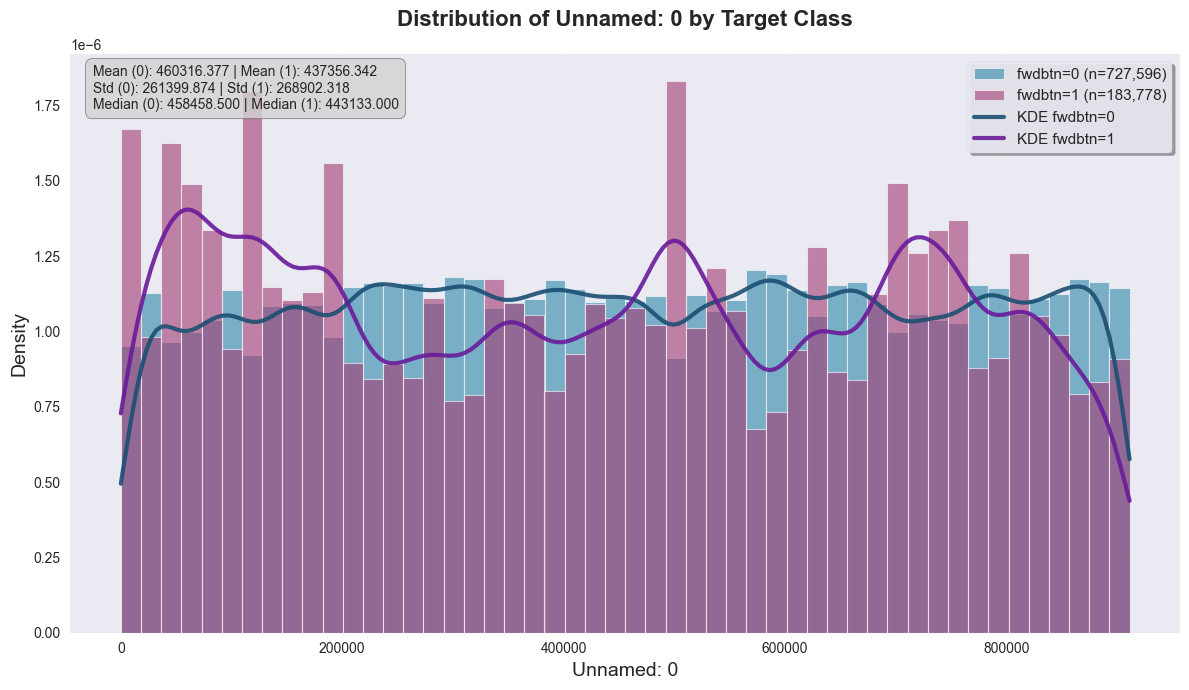


📊 2/6: Analyzing duration_normalized


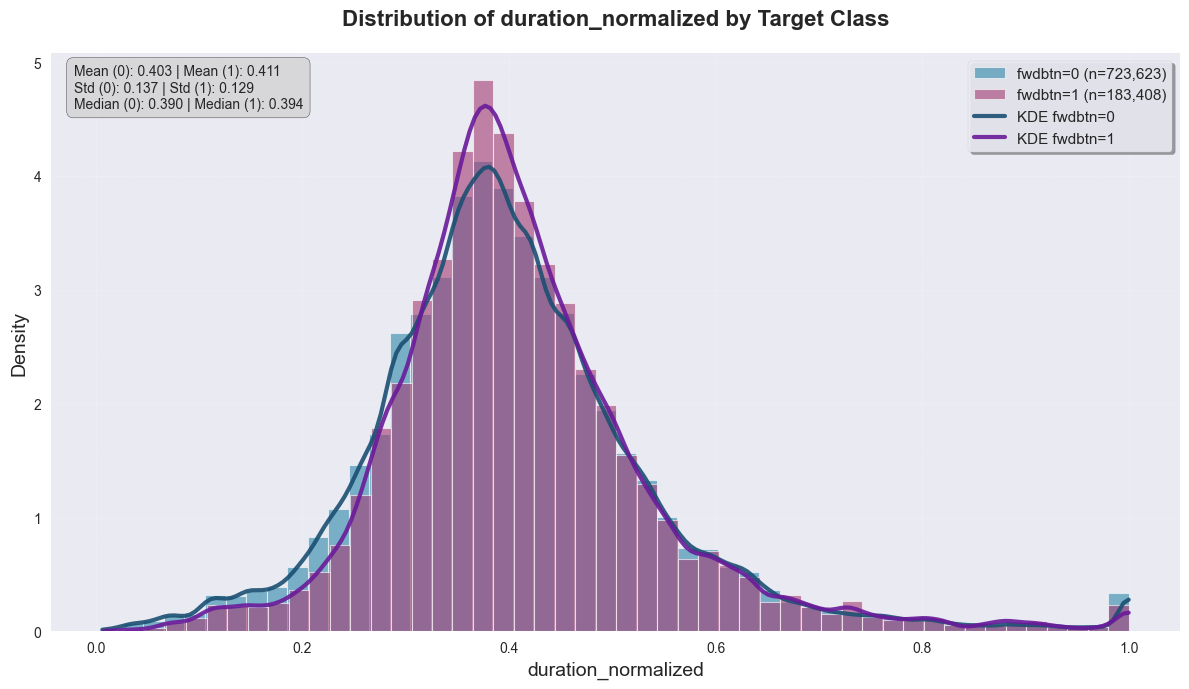


📊 3/6: Analyzing popularity


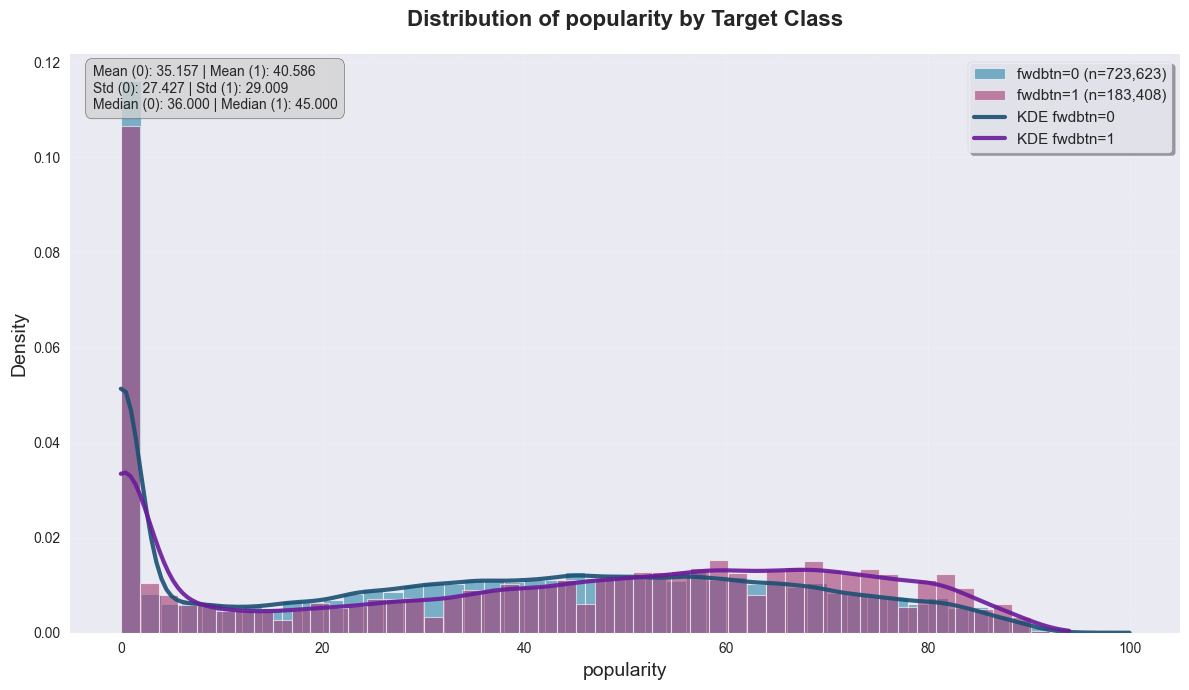


📊 4/6: Analyzing track_number


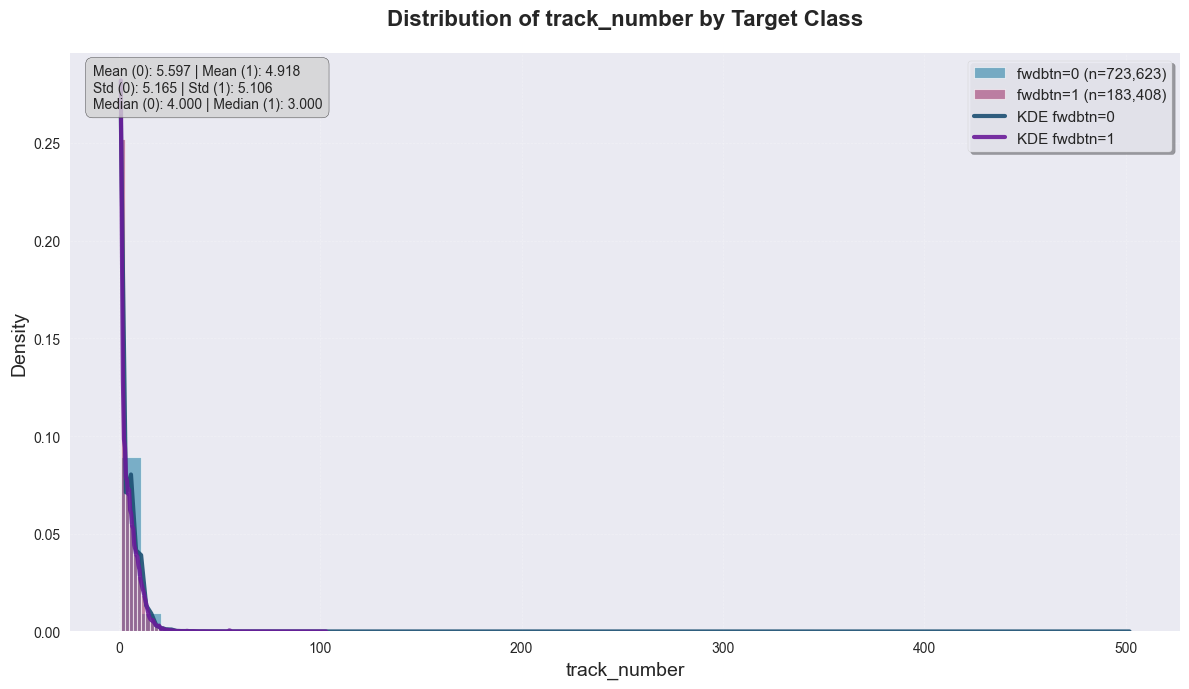


📊 5/6: Analyzing available_markets_count


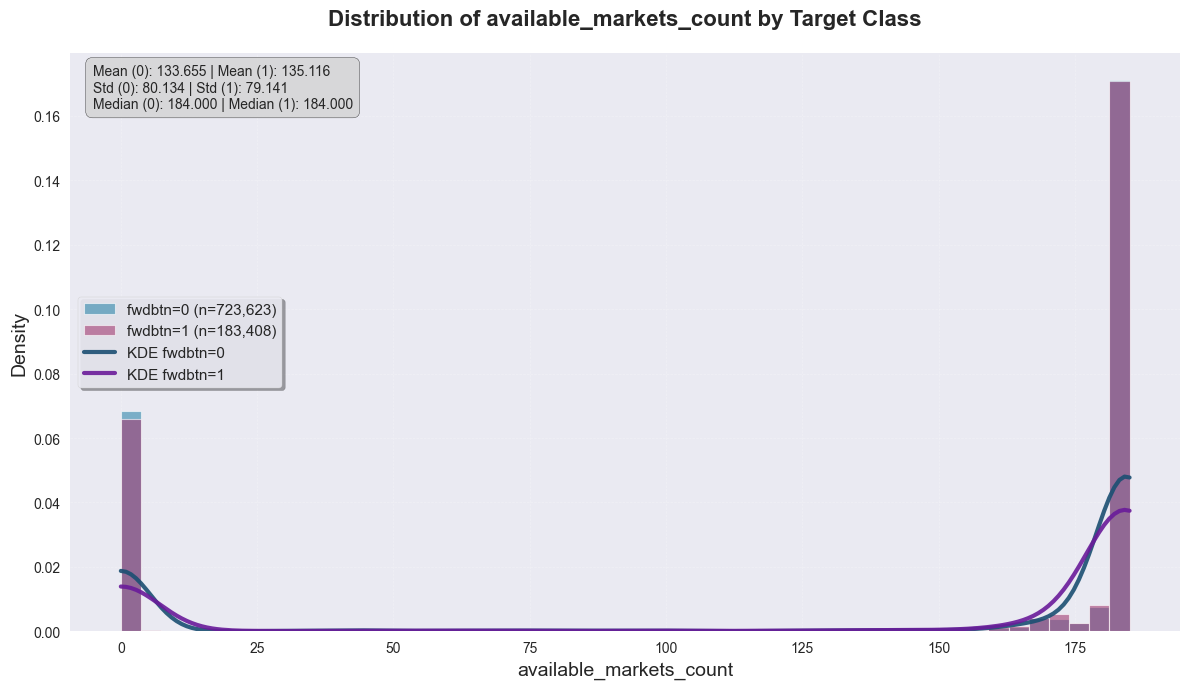


📊 6/6: Analyzing release_year


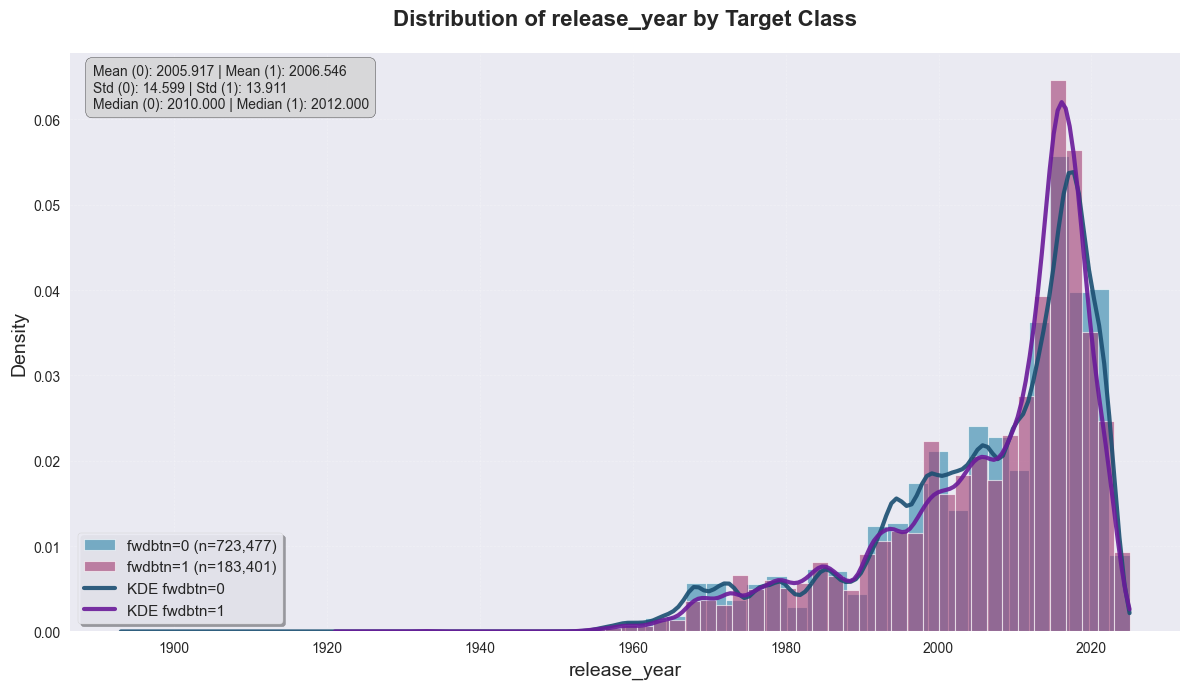


✅ NUMERIC ANALYSIS COMPLETE!
💡 Look for attributes where distributions differ significantly between target classes.
🔍 Focus on: different means, different shapes, or clear separation between classes.


In [13]:
# Generate beautiful histograms for numeric columns
print("🎯 GENERATING DOUBLE HISTOGRAMS FOR NUMERIC ATTRIBUTES")
print("=" * 70)

for i, column in enumerate(numeric_columns):
    print(f"\n📊 {i+1}/{len(numeric_columns)}: Analyzing {column}")
    create_double_histogram(column, df)
    
print("\n" + "=" * 70)
print("✅ NUMERIC ANALYSIS COMPLETE!")
print("💡 Look for attributes where distributions differ significantly between target classes.")
print("🔍 Focus on: different means, different shapes, or clear separation between classes.")



🎯 GENERATING BAR CHARTS FOR CATEGORICAL/BINARY ATTRIBUTES

📊 1/5: Analyzing shuffle


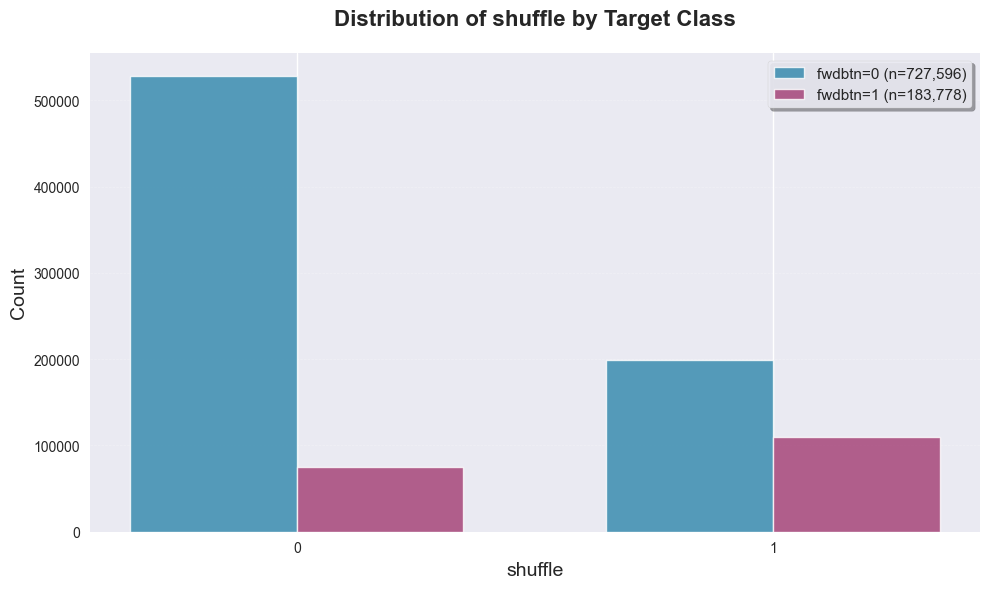


📊 2/5: Analyzing offline


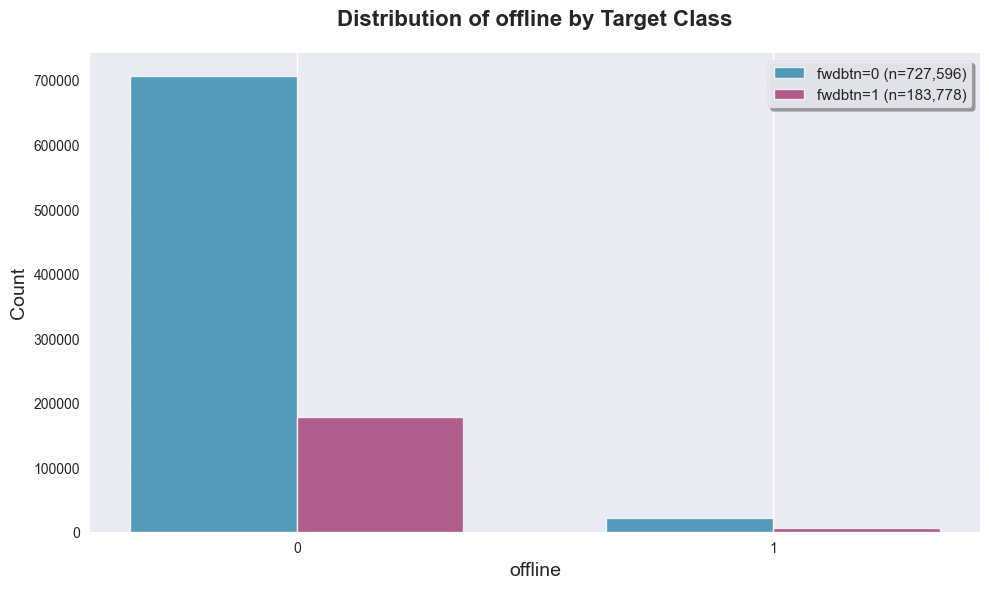


📊 3/5: Analyzing offline_timestamp


KeyboardInterrupt: 

In [14]:
# Generate bar charts for categorical/binary columns
print("\n🎯 GENERATING BAR CHARTS FOR CATEGORICAL/BINARY ATTRIBUTES")
print("=" * 70)

for i, column in enumerate(categorical_columns):
    print(f"\n📊 {i+1}/{len(categorical_columns)}: Analyzing {column}")
    create_categorical_analysis(column, df)
    
print("\n" + "=" * 70)
print("✅ CATEGORICAL ANALYSIS COMPLETE!")
print("💡 Look for attributes where the proportions differ between target classes.")
print("🔍 Focus on: different ratios of 0/1 values or different categorical distributions.")


In [ ]:
# Summary of analysis
print("\n" + "🎉" * 25)
print("📈 COMPLETE ANALYSIS SUMMARY")
print("🎉" * 25)

print(f"\n📊 Total columns analyzed:")
print(f"   • Numeric columns: {len(numeric_columns)}")
print(f"   • Categorical/Binary columns: {len(categorical_columns)}")
print(f"   • Total: {len(numeric_columns) + len(categorical_columns)}")

print(f"\n🎯 Target variable 'fwdbtn' distribution:")
target_dist = df['fwdbtn'].value_counts()
print(f"   • Class 0: {target_dist[0]:,} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"   • Class 1: {target_dist[1]:,} ({target_dist[1]/len(df)*100:.1f}%)")

print(f"\n💡 Key insights to look for:")
print(f"   • Attributes with clearly separated distributions")
print(f"   • Different mean/median values between classes")
print(f"   • Different variance/spread between classes")
print(f"   • Categorical variables with different proportions")

print(f"\n🔍 Most promising attributes will show:")
print(f"   • Clear visual separation between blue and pink distributions")
print(f"   • Different peak locations or shapes")
print(f"   • Significant differences in the statistics box")
